In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

In [3]:
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


The RGD stuff seems to have 2 stability-ish issues that needs to be addressed:
1. once in a while, it fails to minimize the out-of-simplex loss: This seems to be a result of the ReLU loss being too rigid, as the softplus loss with a large beta suffers a similar problem
2. it is not really affected by the initial guess: This is somewhat okay under low-dimensional settings, because we would simply get a permuted alignment instead --> XW * (W^T)B, we get (W^T)B
3. sometimes the result is NA: this is because we are using the true beta to initialize, but sometimes the recovered alignment is XW which corresponds to (W^T)B instead of B

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm
from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

N = 1

temp = sim.ABC_Monte_Carlo.consistency_T2(number_of_iterations = N, 
                                          nodes_set = [300],
                                          beta = [1,1,-4, 5],
                                          alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]],
                                          seeded = True,
                                          constrained = False,
                                          oracle_lat_pos = True,
                                          oracle_align = True,
                                          no_oracle = True)

In [ ]:
model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-4, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
C = model.settings.C

res = torch.tensor(temp.MC_result.est["B_est"]).reshape(N*3, 21).T

torch.linalg.solve(C.T @ C, C.T @ res).T

In [ ]:
i = 1
while i <= 2:
    model = sim.ABC(time = 2,
                nodes = 3,
                beta = [1,1,-4, 5],
                alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
    p = model.settings.p
    torch.manual_seed(i)
    model.update_settings(nodes = 300)
    Z0 = model.synth_data["lat_pos"][0,]
    Z1 = model.synth_data["lat_pos"][1,]
    Y0 = model.synth_data["obs_adj"][0,]
    Y1 = model.synth_data["obs_adj"][1,]


    Z_0 = Align.No_Oracle(Y0, (p-1)).aligned
    X_0 = sim.ABC.gen_X(Y0, Z0, 3)
    ref_Z0 = Z_0[:, :2]
    Z_1 = Align.No_Oracle(Y1, (p-1), ref_Z0).aligned

    # vls.lat_vis(Z0, 3, -1, "Reds")
    # vls.lat_vis(Z1, 3, -1, "Blues")

    test = Dir_Reg.fit(X_0, Z_1)

    res = test.est_result["estimate"].reshape(-1)
    print(torch.linalg.solve(C.T @ C, C.T @ res).T)
    i += 1

Another issue of the no_oracle monte-carlo simulation remains. For some unknown reason, we get the following error:

    --> 270 est_NO = est_no_oracle.est_result["estimate"].reshape(-1)

    271 fish_NO = est_no_oracle.est_result["fisher_info"].reshape(1, -1)
    
    272 method_NO = torch.tensor([[0,0,1]])

IndexError: too many indices for tensor of dimension 2

corresponding seed: 977

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device



print(device)
i = 1

In [ ]:

model = sim.ABC(time = 2,
                nodes = 3,
                beta = [1,1,-4, 5],
                alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
p = model.settings.p
C = model.settings.C

ortho_trans = torch.tensor([[0, 1],[1., 0]])
core = torch.kron(torch.eye(3), ortho_trans)
W_X = torch.block_diag(core, torch.tensor(1.))

torch.manual_seed(i)
model.update_settings(nodes = 4500)
Z0 = model.synth_data["lat_pos"][0,]
Z1 = model.synth_data["lat_pos"][1,]
Y0 = model.synth_data["obs_adj"][0,]
Y1 = model.synth_data["obs_adj"][1,]

Z0_OA = Align.Oracle(Z0, Y0, (p-1)).embed_aligned
X0_OA = sim.ABC.gen_X(Y0, Z0_OA, 3)
Z1_OA = Align.Oracle(Z1, Y1, (p-1)).embed_aligned


Z0_OA_perm = ABC_Reg.ABC_est.mult_W(Z0_OA, ortho_trans)
X0_OA_perm = sim.ABC.gen_X(Y0, Z0_OA_perm, 3)
Z1_OA_perm = ABC_Reg.ABC_est.mult_W(Z1_OA, ortho_trans)

# Z0_NO = Align.No_Oracle(Y0, (p-1)).aligned
# X0_NO = sim.ABC.gen_X(Y0, Z0_NO, 3)
# Z1_NO = Align.No_Oracle(Y1, (p-1)).aligned


test_1 = Dir_Reg.fit(X0_OA, Z1_OA, False) 
# test_2 = Dir_Reg.fit(X0_NO, Z1_NO, False)

res_1 = test_1.est_result["estimate"]
# res_2 = test_2.est_result["estimate"]

print(torch.linalg.solve(C.T @ C, C.T @ res_1.reshape(-1)).T)
# print(torch.linalg.solve(C.T @ C, C.T @ res_2.reshape(-1)).T)


i += 1

In [ ]:
Z0_ASE = Align.Oracle.ASE(Y0, (p-1))
Z1_ASE = Align.Oracle.ASE(Y1, (p-1))

Z0_NO_align_mat = Align.Op_Riemannian_GD(data = Z0_ASE,
                                         initialization = None,
                                         mode = "softplus").align_mat
Z0_NO = ABC_Reg.ABC_est.mult_W(Z0_ASE, Z0_NO_align_mat)

init = Align.Oracle.ortho_proc(Z0_NO[:,:2], Z1_ASE[:,:2])

Z1_NO_init_amat = Align.Op_Riemannian_GD(Z1_ASE, init, "softplus").align_mat

In [ ]:
Z0_ASE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device


In [ ]:
from src import ABC_Reg


i = 1
while i <= 2:
    model = sim.ABC(time = 2,
                    nodes = 3,
                    beta = [1,1,-4, 5],
                    alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
    p = model.settings.p
    C = model.settings.C
    model.update_settings(nodes = 3000)

    
    test = ABC_Reg.ABC_est(embed_dimension = p - 1,
                           two_lat_pos = model.synth_data["lat_pos"],
                           two_adj_mat = model.synth_data["obs_adj"],
                           constrained = False)
    
    test.update_mode("OA")
    res = test.fitted.est_result["estimate"]

    print(torch.linalg.solve(C.T @ C, C.T @ res.reshape(-1)).T)
    i += 1

In [2]:
model = sim.ABC(time = 2,
                nodes = 3,
                beta = [1,1,-4, 5],
                alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
p = model.settings.p
C = model.settings.C
model.update_settings(nodes = 3000)


test = ABC_Reg.est(embed_dimension = p - 1,
                        two_lat_pos = model.synth_data["lat_pos"],
                        two_adj_mat = model.synth_data["obs_adj"],
                        constrained = False,
                        beta_guess = torch.tensor([1.,1,-4, 5]))


In [6]:
test.specify_mode("OL")
res = test.fitted.est_result["estimate"]
print(torch.linalg.solve(C.T @ C, C.T @ res.reshape(-1)).T)

tensor([ 1.0150,  1.0067, -3.9547,  5.3582])


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import igraph as ig
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from src import Simulation as sim
from src import Dir_Reg
from . import Dir_Reg as DR
from src import Dirichlet_Parameter as DP
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [10]:
T, n, alpha_0 = 2, 2100, [[1,1,1], [1,1,1], [1,1,1]]
C = Dir_Reg.fit.gen_constraint(3, True)
model_neg_4 = sim.ABC(time = T,
                    nodes = n,
                    beta = [1,1,-4,5],
                    alpha_0 = alpha_0)

Z0, Z1 = model_neg_4.synth_data["lat_pos"]
Y0, Y1 = model_neg_4.synth_data["obs_adj"]

X0 = sim.ABC.gen_X(Y0, Z0, 3)
result = DR.fit(X0, Z1, beta_guess = torch.tensor([0,0,0,0]), constrained = False, tol = 1)
result.Dir_GD_unconstrained()
est = result.est_result["estimate"]

print(f"estimate of \u03B2 is {torch.linalg.solve(C.T @ C, C.T) @ est.reshape(-1)}")

estimate of β is tensor([ 0.9913,  1.0530, -4.0367,  2.9172])


In [1]:
import torch

In [7]:
A = torch.tensor([[0.1, 0.3, 0.4, 0.2]])
torch.sum(A.T @ A)

tensor(1.0000)

In [6]:
A = torch.tensor([[1,2,3], [2,3,4], [3,4,5]], dtype = torch.float)
I3 = torch.eye(3)

In [6]:
import torch

# Define the parameters for the Dirichlet distribution
alpha = torch.tensor([5.0, 5.0, 5.0])

# Define the number of rows in the matrix
n = 10000  # Change this to whatever number of rows you need

# Generate the Dirichlet random variables
dist = Dirichlet(alpha)
mat = dist.sample((n,))

tensor([[0.2710, 0.3263, 0.4027],
        [0.3149, 0.3557, 0.3294],
        [0.4806, 0.3109, 0.2085],
        [0.3642, 0.0637, 0.5720],
        [0.2398, 0.3975, 0.3628]])

In [17]:
size = []

for i in range(n):
    size.append(torch.norm(mat[0:i,:], p = "fro").item())

<Axes: xlabel='index', ylabel='z'>

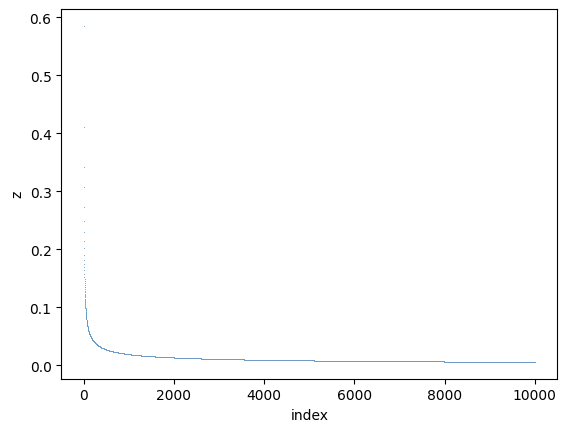

In [25]:
df = pd.DataFrame({"index": list(range(n)), "size": size})
df = df.assign(z = df["size"]/df["index"])

sns.scatterplot(data = df, x = "index", y = "z", s = 0.5)